# Exercise 1


## Part I - accessing b-tagging discriminators

First let's import some useful thigs. For this part we will use __FWLite__, the python bindings to the edm CMSSW classes

In [1]:
import ROOT
import rootpy #hands down, a better version of PyROOT
import rootpy.plotting as plt
import pprint
from DataFormats.FWLite import Events, Handle

Welcome to JupyROOT 6.12/07


In [2]:
events = Events(
    'root://cmseos.fnal.gov//store/user/hats/2019/Tagging/TTToSemiLeptonic_RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15/D7F68ED3-7D8A-0A4E-A53E-D5557F11760C.root')

This is just a python trick to get the first event

In [3]:
event = events.__iter__().next()

Now, let's create a handle, like you would do in C++. If you use FWLite for your analysis, remember to create the handle __before your event loop!__ Creating a handle is quite slow in python, so better do it only once.

In [4]:
handle = Handle('vector<pat::Jet>')

Now get the jet collection

In [5]:
event.getByLabel('slimmedJets', handle)
jets = handle.product()
print jets

<ROOT.vector<pat::Jet> object at 0x145df500>


Now that we have our vector of jets, we can check the first element and ask its methods.

B-tagging outputs are called _discriminator_, so let's use python's reflection abilities to see what's inside the `pat::Jet` that we can use. Otherwise you can always use [doxygen](http://cmsdoxygen.web.cern.ch/cmsdoxygen/CMSSW_9_2_8/doc/html/d6/d00/classpat_1_1Jet.html).

In [6]:
[i for i in dir(jets[0]) if 'disc' in i.lower()]

['addBDiscriminatorPair', 'bDiscriminator', 'getPairDiscri']

As you can see there are three methods that look interesting. One for adding the discriminators and two to get them, we will use the second one.

In [7]:
jets[0].getPairDiscri()

<ROOT.vector<pair<string,float> > object at 0x148f3d58>

As you can see this returns a `std::vector` containing pairs of `std::string` and `float`, corresponding to the discriminator name and its respective value. Let's check all the discriminators available:

In [8]:
[i.first for i in jets[0].getPairDiscri()]

['pfJetBProbabilityBJetTags',
 'pfJetProbabilityBJetTags',
 'pfTrackCountingHighEffBJetTags',
 'pfSimpleSecondaryVertexHighEffBJetTags',
 'pfSimpleInclusiveSecondaryVertexHighEffBJetTags',
 'pfCombinedSecondaryVertexV2BJetTags',
 'pfCombinedInclusiveSecondaryVertexV2BJetTags',
 'softPFMuonBJetTags',
 'softPFElectronBJetTags',
 'pfCombinedMVAV2BJetTags',
 'pfCombinedCvsLJetTags',
 'pfCombinedCvsBJetTags',
 'pfDeepCSVJetTags:probb',
 'pfDeepCSVJetTags:probc',
 'pfDeepCSVJetTags:probudsg',
 'pfDeepCSVJetTags:probbb',
 'pfDeepCSVDiscriminatorsJetTags:BvsAll',
 'pfDeepCSVDiscriminatorsJetTags:CvsB',
 'pfDeepCSVDiscriminatorsJetTags:CvsL',
 'pfDeepFlavourJetTags:probb',
 'pfDeepFlavourJetTags:probc',
 'pfDeepFlavourJetTags:probg',
 'pfDeepFlavourJetTags:problepb',
 'pfDeepFlavourJetTags:probbb',
 'pfDeepFlavourJetTags:probuds']

## Part II - A few comments on event loops

Let's run a simple event loop counting the events:

In [9]:
counter = 0
for evt in events:
    counter += 1
print counter

80000


OK, pretty standard, right? Now, let's try to do it __again__

In [10]:
counter = 0
for evt in events:
    counter += 1
print counter

0


#### What happened?
To save memory the `FWLite.Events` class behaves like a generator, hence once you loop over one entry, that entry is forgotten and you cannot re-run over it, unless you re-load the file completely. Keep that in mind when playing with it!

Let's reload the file, you can always re-execute this cell how many times you need to reset this feature and run on the full set of events

In [11]:
events = Events(
    'root://cmseos.fnal.gov//store/user/hats/2019/Tagging/TTToSemiLeptonic_RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15/D7F68ED3-7D8A-0A4E-A53E-D5557F11760C.root'
)

## Part III - plotting the b-tagging discriminator
Now, let's plot few discriminator outputs for jets with $p_T > 20$ GeV and $|\eta| < 2.4$

In [12]:
histograms = {
    'CSV' : plt.Hist(100,0,1.1),
    'deepCSV' : plt.Hist(100,0,1.1),
}

In [13]:
####### YOUR CODE HERE! ######
# To fill the histogram
#histograms['CSV'].fill(...)
#Remember, DeepCSV needs both 'pfDeepCSVJetTags:probb' + 'pfDeepCSVJetTags:probbb'

Now, let's plot it! (some cosmetics first, though)

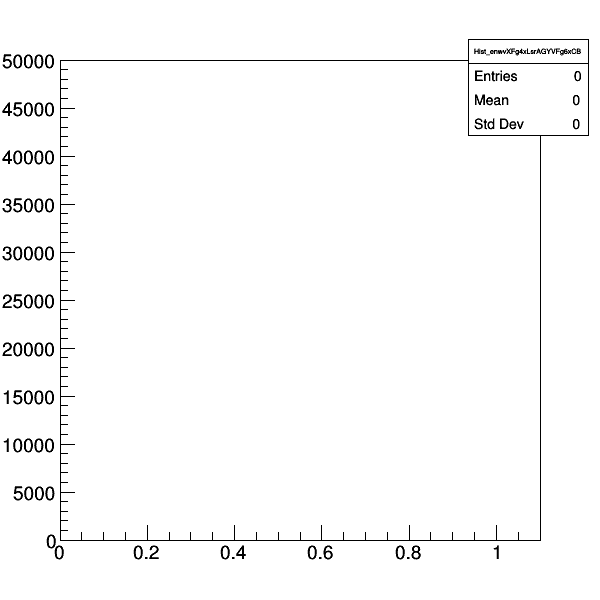

In [13]:
histograms['CSV'].markercolor = 'blue'
histograms['deepCSV'].markercolor = 'red'
histograms['deepCSV'].xaxis.title = 'DeepCSV'
histograms['deepCSV'].yaxis.title = 'Events'
canvas = plt.Canvas(600, 600)
histograms['CSV'].Draw("hist e")
histograms['CSV'].yaxis.SetRangeUser(0,50000)
histograms['deepCSV'].Draw('same hist e')
canvas.Draw() #You need this to display inline

## Part IV - FatJet and sub-jet b-tagging

Subjet b tagging is in many respects similar to the b tagging of the "standard" ak4 jets. However, there are some important differences to consider. Since subjets can get close to one another, using a fixed-size track association cone could lead to double-counting of tracks if they are associated to more than one subjet. To avoid such track sharing, the explicit jet-track association is used for subjets where tracks linked to the charged PF jet constituents are associated to the subjet. Similarly, a fixed-size association cone can lead to ambiguities in the secondary vertex and jet flavor assignment for subjets. This problem is resolved by ghost-associating secondary vertices and generator level hadrons/partons to subjets (see [here](https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideBTagMCTools) for more details). An important thing to keep in mind is that the ghost association, in addition to the subjet collection of, also requires collections of original and groomed fat jets to be present since the "ghost" constituents are first associated to fat jets and then to subjets of the groomed fat jets.

A version of fat-jets and sub-jets are already stored in the `miniAOD` event content, clustered with the `AK8` algorithm (anti-$k_T$ with a 0.8 cone). 
  - How many discriminators you see available for the FatJet? Is there any difference from the the ones for AK4?
  - Can you plot the `CSVv2` and `DeepCSV` discriminator output for the Fat-Jets and their sub-jets?
      - __Pro:__ Using `hadronFlavour()` to get the different flavour identification (5: b jet, 4: c jet, 0: light) can you separate the components and plot them in a stacked histogram?

__Hint:__ use [doxygen](http://cmsdoxygen.web.cern.ch/cmsdoxygen/CMSSW_9_2_8/doc/html/d6/d00/classpat_1_1Jet.html) and the interactive nature of python to test yout commands on a single event to test the commands before running the full event loop

In [15]:
#
# Your code here, this time it will take a while
#